# Simulation of the wireless communication system project in Signals and transforms

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import sounddevice as sd
import wcslib as wcs

ModuleNotFoundError: No module named 'matplotlib'

## Parameters

In [2]:
channel_id = 17
Tb = 0.02
Ac = 1
fc = 4400
bs = 1 / Tb
wc = 27646    # rad/s
alpha = 2 * np.pi * 200
# Ar = |H(w)| * Ac
tr = 1
phi = -wc*tr

# Lab 2
K = 10
s_freq = fc * K
Ts = 1 / s_freq 

Ap = 2
As = 40
wp = [4350, 4450]
ws = [4300, 4500]

# Message to be transmitted
data = "Hello World!"

## Filter design

In [3]:
# TODO: Design the filters

# Nb, w_c = signal.buttord(wp, ws, Ap, As, analog=False)
# Nb = np.abs(np.ceil(Nb))
# bb, ab = signal.butter(Nb, w_c, btype='bandpass' analog=False)
# wb, Hb = signal.freqz(bb, ab)
# print(f"Bandpass filter order: {Nb}")

## Transmitter

In [4]:
# Convert string to bit sequence
bs = wcs.encode_string(data)
    
# Encode baseband signal
xb = wcs.encode_baseband_signal(bs, Tb, s_freq)

# TODO: Implement transmitter code here
t = np.arange(0, xb.shape[0]) * Ts 
xc = Ac * np.sin(wc * t)
xm = xb * xc
xt = xm.copy()
# xt = ...
# Ensure the signal is mono, then play through speakers
xt_play = np.stack((xt, np.zeros(xt.shape)), axis=1)
sd.play(xt_play, s_freq, blocking=True)

NameError: name 'wcs' is not defined

## Simulate transmission

In [ ]:
yr = wcs.simulate_channel(xt, s_freq, channel_id)

## Receiver

Received: [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 

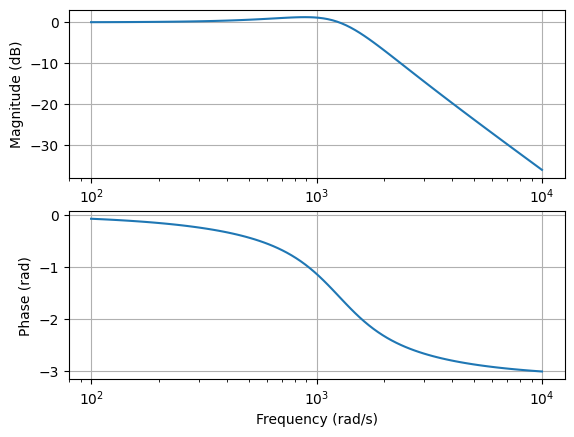

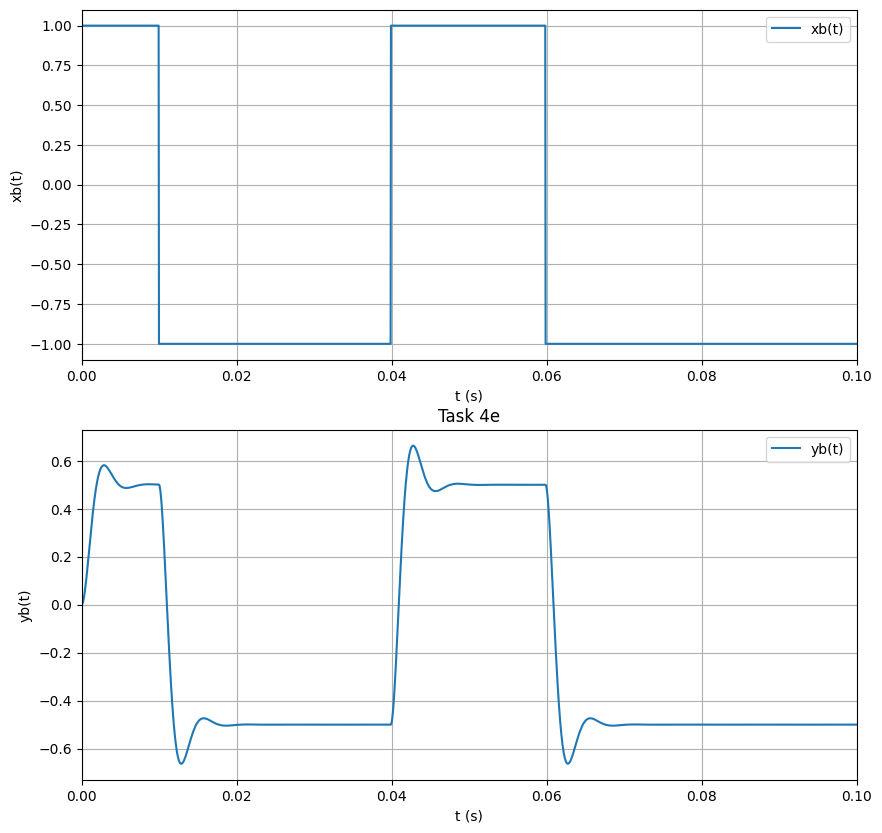

In [ ]:
# TODO: Put your receiver code (filtering, demodulation, etc.) here

yd = xm * np.sin(wc * t)
num = [alpha**2]
den = [1, alpha, alpha**2]
H = signal.TransferFunction(num, den)
__, yb, __ = signal.lsim(H, yd, t)

# T = xt.shape[0] * Ts
# yr = sd.rec(int(T/Ts), samplerate=s_freq, channels=1, blocking=True)
# yr = yr[:, 0]   

# # Calculate complex baseband signal
# ybi = yr * np.cos(wc*t)
# ybq = yr * np.sin(wc*t)
# yb = ybi + 1j*ybq

# Symbol decoding
br = wcs.decode_baseband_signal(yb, Tb, s_freq)

data_rx = wcs.decode_string(br)
print('Received: ' + data_rx)